Calculando métodos e métricas considerando a classificação binária do dataset de creditcardfraud como operações fraudulentas ou não.

In [1]:
import pandas as pd

og_df_pre = pd.read_csv("creditcard.zip")
og_df_norm = pd.read_csv("creditcard_norm.zip")


## Separando as classes do dataset

In [2]:
from sklearn.model_selection import train_test_split
# Colunas para separar o dataset da classe
cols = og_df_pre.columns.tolist()
classe = cols.pop(2)

num_amostra = 500
df_pre = og_df_pre.sample(num_amostra, random_state=42)
df_norm = og_df_norm.sample(2*num_amostra, random_state=42)

# todas as linhas
X_pre = df_pre.loc[:,cols]  
y_pre = df_pre[classe].iloc[:]
X_pre_train, X_pre_test, y_pre_train, y_pre_test= train_test_split(X_pre, y_pre, test_size=0.3, random_state=42)

X_norm = df_norm.loc[:,cols]
y_norm = df_norm[classe].iloc[:]
X_norm_train, X_norm_test, y_norm_train, y_norm_test= train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)


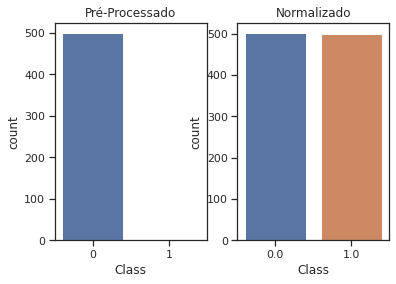

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

y_pre.value_counts()
fig, ax =plt.subplots(1,2)
sns.countplot(df_pre["Class"], ax=ax[0]).set(title='Pré-Processado')
sns.countplot(df_norm["Class"], ax=ax[1]).set(title='Normalizado')
fig.show()

## KKN


In [43]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import  KNeighborsClassifier
dist = ["euclidean","manhattan"]
results_knn_pre = []
for d in dist:
    for i in range(3,12,2):
        neigh = KNeighborsClassifier(n_neighbors=i, metric=d, n_jobs=-1)
        knn = cross_validate(neigh, X_pre, y_pre, 
            scoring=('recall', 'precision', 'balanced_accuracy','f1'), 
            cv= 10, n_jobs=-1, return_estimator= True)        
        results_knn_pre.append(knn)

        

In [44]:
tabelas_knn = []
df_knn = pd.DataFrame(columns=["DF","K","Distância","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_knn_pre):
        est = r["estimator"][0]
        obj = {
            "DF": "PreProcessamento",
            "K": est.n_neighbors,
            "Distância": est.metric,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_balanced_accuracy'].mean(),
            "Acurácia.dp":r['test_balanced_accuracy'].std()
        }
        df_knn.loc[i] = obj      
df_knn

,DF,K,Distância,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,PreProcessamento,3,euclidean,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
1,PreProcessamento,5,euclidean,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
2,PreProcessamento,7,euclidean,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
3,PreProcessamento,9,euclidean,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
4,PreProcessamento,11,euclidean,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
5,PreProcessamento,3,manhattan,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
6,PreProcessamento,5,manhattan,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
7,PreProcessamento,7,manhattan,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
8,PreProcessamento,9,manhattan,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
9,PreProcessamento,11,manhattan,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15


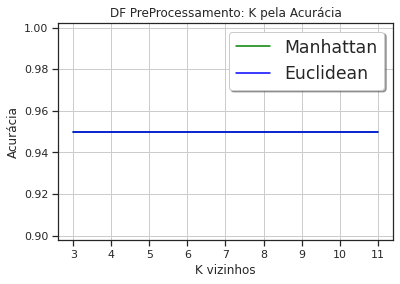

In [45]:
import matplotlib.pyplot as plt

man = df_knn.loc[df_knn["Distância"] == 'manhattan',["K","Acurácia"]]
euc = df_knn.loc[df_knn["Distância"] != 'manhattan',["K","Acurácia"]]

plt.plot('K','Acurácia', data=man, color='green',label='Manhattan')
plt.plot('K','Acurácia', data=euc, color='blue',label='Euclidean')

plt.xlabel('K vizinhos')
plt.ylabel('Acurácia')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.grid(zorder=0)

plt.title(f'DF {df_knn.iloc[0,0]}: K pela Acurácia')
plt.show()

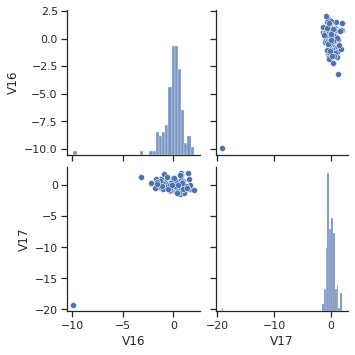

In [46]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(X_pre_test[["V16","V17"]])

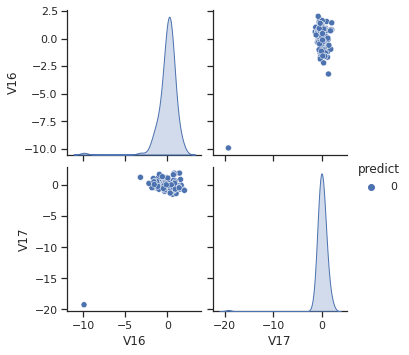

In [47]:
melhor_knn_pre = max([(r["estimator"][0],r["test_balanced_accuracy"].mean()) for r in results_knn_pre],key=lambda obj: obj[1])
p_knn_pre_test = melhor_knn_pre[0].predict(X_pre_test)
p_knn = X_pre_test
df2 = p_knn.assign(predict=p_knn_pre_test)

sns.set_theme(style="ticks")
sns.pairplot(df2[["V16","V17","predict"]],hue="predict")

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import  KNeighborsClassifier
dist = ["euclidean","manhattan"]
results = []
for d in dist:
    for i in range(3,12,2):
        neigh = KNeighborsClassifier(n_neighbors=i, metric=d, n_jobs=-1)        
        knn = cross_validate(neigh, X_norm, y_norm, 
            scoring=('recall', 'precision', 'accuracy','f1'), 
            cv= 10, n_jobs=-1, return_estimator= True)        
        results.append(knn)

        

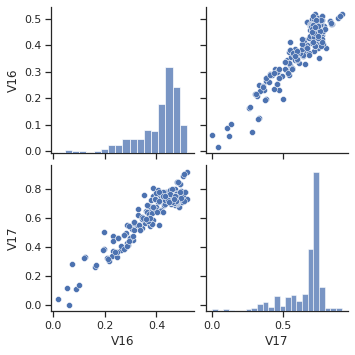

In [49]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(X_norm_test[["V16","V17"]])

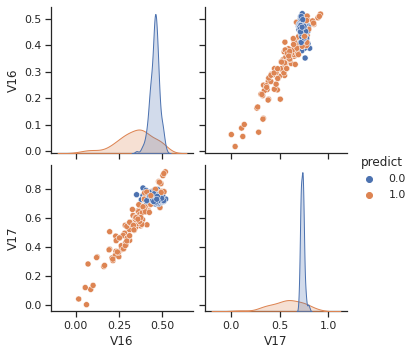

In [50]:
melhor_knn = max([(r["estimator"][0],r["test_accuracy"].mean()) for r in results],key=lambda obj: obj[1])
p_knn_norm_test = melhor_knn[0].predict(X_norm_test)
p_knn = X_norm_test
df2 = p_knn.assign(predict=p_knn_norm_test)

sns.set_theme(style="ticks")
sns.pairplot(df2[["V16","V17","predict"]],hue="predict")

In [51]:
tabelas_knn = []
df_knn = pd.DataFrame(columns=["DF","K","Distância","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results):
        est = r["estimator"][0]
        obj = {
            "DF": "Normalizado",
            "K": est.n_neighbors,
            "Distância": est.metric,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_accuracy'].mean(),
            "Acurácia.dp":r['test_accuracy'].std()
        }
        df_knn.loc[i] = obj      
df_knn

,DF,K,Distância,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,Normalizado,3,euclidean,0.899837,0.048101,0.971985,0.017013,0.933849,0.028178,0.937,0.025710
1,Normalizado,5,euclidean,0.885796,0.050583,0.959170,0.020359,0.920189,0.028894,0.924,0.026153
2,Normalizado,7,euclidean,0.867755,0.039124,0.959077,0.027036,0.910346,0.021621,0.915,0.019621
3,Normalizado,9,euclidean,0.867714,0.043143,0.980227,0.014925,0.919776,0.022181,0.925,0.019105
4,Normalizado,11,euclidean,0.865714,0.043911,0.989083,0.014267,0.922525,0.023080,0.928,0.019900
5,Normalizado,3,manhattan,0.901837,0.048481,0.970303,0.026472,0.934097,0.031088,0.937,0.029000
6,Normalizado,5,manhattan,0.891796,0.043048,0.971467,0.017319,0.929518,0.028259,0.933,0.026096
7,Normalizado,7,manhattan,0.883796,0.039722,0.962866,0.022451,0.921299,0.028095,0.925,0.026173
8,Normalizado,9,manhattan,0.877796,0.046770,0.984164,0.017777,0.927424,0.030738,0.932,0.027857
9,Normalizado,11,manhattan,0.869755,0.043996,0.990637,0.011474,0.925826,0.028469,0.931,0.025475


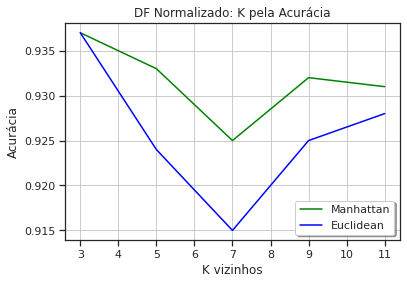

In [56]:
import matplotlib.pyplot as plt

man = df_knn.loc[df_knn["Distância"] == 'manhattan',["K","Acurácia"]]
euc = df_knn.loc[df_knn["Distância"] != 'manhattan',["K","Acurácia"]]

plt.plot('K','Acurácia', data=man, color='green',label='Manhattan')
plt.plot('K','Acurácia', data=euc, color='blue',label='Euclidean')

plt.xlabel('K vizinhos')
plt.ylabel('Acurácia')
plt.legend(loc='lower right', shadow=True)
plt.grid(zorder=0)

plt.title(f'DF {df_knn.iloc[0,0]}: K pela Acurácia')
plt.show()

<h2>MLP</h2>

In [57]:
from sklearn.neural_network import MLPClassifier
results_mlp_pre = []
for i in range(2, 15, 3):
    clf_mlp = MLPClassifier(solver='adam', alpha=1e-5, 
                        hidden_layer_sizes=i, random_state=1, max_iter=1000)
    mlp = cross_validate(clf_mlp, X_pre, y_pre, 
            scoring=('recall', 'precision', 'balanced_accuracy','f1'), 
            cv= 10, n_jobs=-1, return_estimator= True)        
    results_mlp_pre.append(mlp)

In [58]:
tabelas_mlp = []
df_mlp_pre = pd.DataFrame(columns=["DF","Neurônios na camada escondida","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_mlp_pre):
        est = r["estimator"][0]
        obj = {
            "DF": "PreProcessamento",
            "Neurônios na camada escondida": est.hidden_layer_sizes,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_balanced_accuracy'].mean(),
            "Acurácia.dp":r['test_balanced_accuracy'].std()
        }
        df_mlp_pre.loc[i] = obj      
df_mlp_pre

,DF,Neurônios na camada escondida,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,PreProcessamento,2,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
1,PreProcessamento,5,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
2,PreProcessamento,8,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15
3,PreProcessamento,11,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15
4,PreProcessamento,14,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15


In [59]:
from sklearn.neural_network import MLPClassifier
results_mlp_norm = []
for i in range(2, 15, 3):
    clf_mlp = MLPClassifier(solver='adam', alpha=1e-5, 
                        hidden_layer_sizes=i, random_state=1, max_iter=1000)
    mlp = cross_validate(clf_mlp, X_norm, y_norm, 
            scoring=('recall', 'precision', 'accuracy','f1'), 
            cv= 10, n_jobs=-1, return_estimator= True)        
    results_mlp_norm.append(mlp)

In [60]:
tabelas_mlp = []
df_mlp_norm = pd.DataFrame(columns=["DF","Neurônios na camada escondida","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_mlp_norm):
        est = r["estimator"][0]
        obj = {
            "DF": "Normalizado",
            "Neurônios na camada escondida": est.hidden_layer_sizes,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_accuracy'].mean(),
            "Acurácia.dp":r['test_accuracy'].std()
        }
        df_mlp_norm.loc[i] = obj      
df_mlp_norm

,DF,Neurônios na camada escondida,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,Normalizado,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.501,0.003000
1,Normalizado,5,0.881755,0.036298,0.985222,0.020710,0.929946,0.017532,0.934,0.015620
2,Normalizado,8,0.887755,0.040255,0.978866,0.024786,0.930349,0.021804,0.934,0.020100
3,Normalizado,11,0.881755,0.043330,0.978847,0.024572,0.926890,0.022344,0.931,0.020224
4,Normalizado,14,0.877755,0.039441,0.980861,0.025551,0.925705,0.021976,0.930,0.020000


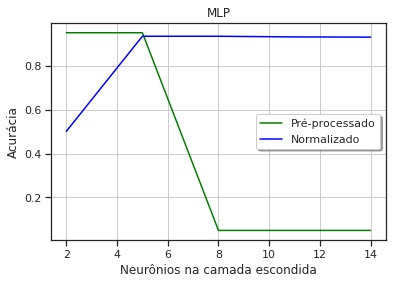

In [64]:
import matplotlib.pyplot as plt

pre = df_mlp_pre.loc[df_mlp_pre["DF"] == 'PreProcessamento',["Neurônios na camada escondida","Acurácia"]]
norm = df_mlp_norm.loc[df_mlp_norm["DF"] != 'PreProcessamento',["Neurônios na camada escondida","Acurácia"]]

plt.plot('Neurônios na camada escondida','Acurácia', data=pre, color='green',label='Pré-processado')
plt.plot('Neurônios na camada escondida','Acurácia', data=norm, color='blue',label='Normalizado')

plt.xlabel('Neurônios na camada escondida')
plt.ylabel('Acurácia')
plt.legend(loc='center right', shadow=True)
plt.grid(zorder=0)

plt.title("MLP")
plt.show()

# Árvores de decisão

In [69]:
from sklearn.tree import DecisionTreeClassifier

# Usando Gini
results_tree_gini_pre = []
results_tree_gini_norm = []
for i in range(5,15,2):
    dec_tree = DecisionTreeClassifier(criterion="gini", max_depth=i, min_samples_leaf=i-2, random_state=42)
    cv_res = cross_validate(dec_tree,X_pre,y_pre,
                    scoring=('recall', 'precision', 'balanced_accuracy','f1'), 
                    cv= 10, n_jobs=-1, return_estimator= True)
    results_tree_gini_pre.append(cv_res)
    cv_res = cross_validate(dec_tree,X_norm,y_norm,
                    scoring=('recall', 'precision', 'accuracy','f1'), 
                    cv= 10, n_jobs=-1, return_estimator= True)
    results_tree_gini_norm.append(cv_res)



In [103]:
df_tree_gini_pre = pd.DataFrame(columns=["DF","Tipo","Profundidade Máxima","Número de Exemplos","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_tree_gini_pre):
        est = r["estimator"][0]
        obj = {
            "DF": "PreProcessamento",
            "Tipo":"Gini",
            "Profundidade Máxima": est.max_depth,
            "Número de Exemplos": est.min_samples_leaf,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_balanced_accuracy'].mean(),
            "Acurácia.dp":r['test_balanced_accuracy'].std()
        }
        df_tree_gini_pre.loc[i] = obj      
df_tree_gini_pre

,DF,Tipo,Profundidade Máxima,Número de Exemplos,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,PreProcessamento,Gini,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
1,PreProcessamento,Gini,7,5,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
2,PreProcessamento,Gini,9,7,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
3,PreProcessamento,Gini,11,9,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
4,PreProcessamento,Gini,13,11,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15


[Text(167.4, 108.72, 'gini = 0.0\nsamples = 450\nvalue = 450.0')]

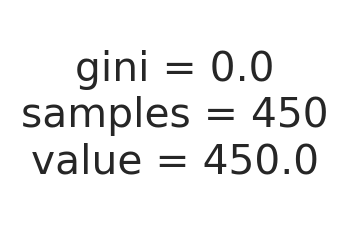

In [112]:
from sklearn.tree import plot_tree

melhor_arvore = max([ [r["test_balanced_accuracy"].mean(),r["test_balanced_accuracy"].std(),r["estimator"][0]] for r in results_tree_gini_pre], key=lambda x : x[0])
plot_tree(melhor_arvore[2], class_names=True)


In [104]:
df_tree_gini_norm = pd.DataFrame(columns=["DF","Tipo","Profundidade Máxima","Número de Exemplos","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_tree_gini_norm):
        est = r["estimator"][0]
        obj = {
            "DF": "PreProcessamento",
            "Tipo":"Gini",
            "Profundidade Máxima": est.max_depth,
            "Número de Exemplos": est.min_samples_leaf,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_accuracy'].mean(),
            "Acurácia.dp":r['test_accuracy'].std()
        }
        df_tree_gini_norm.loc[i] = obj      
df_tree_gini_norm

,DF,Tipo,Profundidade Máxima,Número de Exemplos,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,PreProcessamento,Gini,5,3,0.899755,0.038083,0.932078,0.047883,0.914681,0.031436,0.916,0.032000
1,PreProcessamento,Gini,7,5,0.921796,0.032945,0.925064,0.049494,0.922225,0.025775,0.922,0.027495
2,PreProcessamento,Gini,9,7,0.929796,0.037318,0.924401,0.037292,0.926153,0.022823,0.926,0.023324
3,PreProcessamento,Gini,11,9,0.899755,0.038083,0.930085,0.039925,0.913535,0.021717,0.915,0.022023
4,PreProcessamento,Gini,13,11,0.899796,0.042900,0.930947,0.047189,0.913633,0.026825,0.915,0.027659


[Text(110.25865384615385, 206.56799999999998, 'X[15] <= 0.583\ngini = 0.5\nsamples = 900\nvalue = [451, 449]\nclass = y[0]'),
 Text(51.50769230769231, 184.824, 'X[15] <= 0.554\ngini = 0.04\nsamples = 393\nvalue = [8, 385]\nclass = y[1]'),
 Text(25.753846153846155, 163.07999999999998, 'X[12] <= 0.329\ngini = 0.005\nsamples = 373\nvalue = [1, 372]\nclass = y[1]'),
 Text(12.876923076923077, 141.336, 'gini = 0.18\nsamples = 10\nvalue = [1, 9]\nclass = y[1]'),
 Text(38.63076923076923, 141.336, 'gini = 0.0\nsamples = 363\nvalue = [0, 363]\nclass = y[1]'),
 Text(77.26153846153846, 163.07999999999998, 'X[15] <= 0.58\ngini = 0.455\nsamples = 20\nvalue = [7, 13]\nclass = y[1]'),
 Text(64.38461538461539, 141.336, 'gini = 0.463\nsamples = 11\nvalue = [7, 4]\nclass = y[0]'),
 Text(90.13846153846154, 141.336, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = y[1]'),
 Text(169.0096153846154, 184.824, 'X[4] <= 0.783\ngini = 0.221\nsamples = 507\nvalue = [443, 64]\nclass = y[0]'),
 Text(128.76923076923

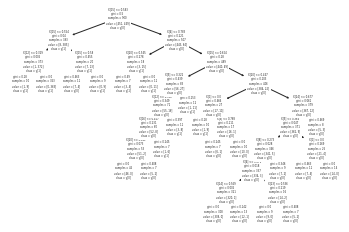

In [113]:
melhor_arvore = max([ [r["test_accuracy"].mean(),r["test_accuracy"].std(),r["estimator"][0]] for r in results_tree_gini_norm], key=lambda x : x[0])
plot_tree(melhor_arvore[2], class_names=True)

In [70]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Usando Entropy
results_tree_entropy_pre = []
results_tree_entropy_norm = []
for i in range(5,15,2):
    dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth=i, min_samples_leaf=i-2, random_state=42)
    cv_res = cross_validate(dec_tree,X_pre,y_pre,
                    scoring=('recall', 'precision', 'balanced_accuracy','f1'), 
                    cv= 10, n_jobs=-1, return_estimator= True)
    results_tree_entropy_pre.append(cv_res)
    cv_res = cross_validate(dec_tree,X_norm,y_norm,
                    scoring=('recall', 'precision', 'accuracy','f1'), 
                    cv= 10, n_jobs=-1, return_estimator= True)
    results_tree_entropy_norm.append(cv_res)

In [106]:
df_tree_entropy_pre = pd.DataFrame(columns=["DF","Tipo","Profundidade Máxima","Número de Exemplos","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_tree_entropy_pre):
        est = r["estimator"][0]
        obj = {
            "DF": "PreProcessamento",
            "Tipo":"Entropy",
            "Profundidade Máxima": est.max_depth,
            "Número de Exemplos": est.min_samples_leaf,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_balanced_accuracy'].mean(),
            "Acurácia.dp":r['test_balanced_accuracy'].std()
        }
        df_tree_entropy_pre.loc[i] = obj      
df_tree_entropy_pre

,DF,Tipo,Profundidade Máxima,Número de Exemplos,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,PreProcessamento,Entropy,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
1,PreProcessamento,Entropy,7,5,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
2,PreProcessamento,Entropy,9,7,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
3,PreProcessamento,Entropy,11,9,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15
4,PreProcessamento,Entropy,13,11,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.15


[Text(167.4, 108.72, 'entropy = 0.0\nsamples = 450\nvalue = 450.0')]

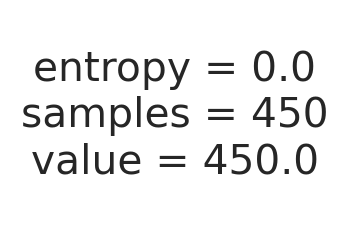

In [114]:
melhor_arvore = max([ [r["test_balanced_accuracy"].mean(),r["test_balanced_accuracy"].std(),r["estimator"][0]] for r in results_tree_entropy_pre], key=lambda x : x[0])
plot_tree(melhor_arvore[2], class_names=True)

In [108]:
df_tree_entropy_norm = pd.DataFrame(columns=["DF","Tipo","Profundidade Máxima","Número de Exemplos","Sensibilidade","Sensibilidade.dp","Precisão","Precisão.dp","F1","F1.dp","Acurácia","Acurácia.dp"])
for i,r in enumerate(results_tree_entropy_norm):
        est = r["estimator"][0]
        obj = {
            "DF": "PreProcessamento",
            "Tipo":"Entropy",
            "Profundidade Máxima": est.max_depth,
            "Número de Exemplos": est.min_samples_leaf,
            "Sensibilidade":r['test_recall'].mean(),
            "Sensibilidade.dp":r['test_recall'].std(),
            "Precisão":r['test_precision'].mean(),
            "Precisão.dp":r['test_precision'].std(),
            "F1":r['test_f1'].mean(),
            "F1.dp":r['test_f1'].std(),
            "Acurácia":r['test_accuracy'].mean(),
            "Acurácia.dp":r['test_accuracy'].std()
        }
        df_tree_entropy_norm.loc[i] = obj      
df_tree_entropy_norm

,DF,Tipo,Profundidade Máxima,Número de Exemplos,Sensibilidade,Sensibilidade.dp,Precisão,Precisão.dp,F1,F1.dp,Acurácia,Acurácia.dp
0,PreProcessamento,Entropy,5,3,0.915796,0.048072,0.942146,0.033915,0.927470,0.024537,0.929,0.023000
1,PreProcessamento,Entropy,7,5,0.925878,0.033477,0.927992,0.043137,0.926071,0.027048,0.926,0.027641
2,PreProcessamento,Entropy,9,7,0.929918,0.037083,0.919752,0.043142,0.923498,0.020783,0.923,0.021471
3,PreProcessamento,Entropy,11,9,0.931918,0.032427,0.913931,0.039871,0.921826,0.019767,0.921,0.020712
4,PreProcessamento,Entropy,13,11,0.923878,0.031941,0.922508,0.041601,0.922193,0.021503,0.922,0.022716


[Text(114.53684210526316, 199.32, 'X[15] <= 0.554\nentropy = 1.0\nsamples = 900\nvalue = [451, 449]\nclass = y[0]'),
 Text(52.863157894736844, 163.07999999999998, 'X[12] <= 0.318\nentropy = 0.027\nsamples = 373\nvalue = [1, 372]\nclass = y[1]'),
 Text(35.242105263157896, 126.83999999999999, 'X[1] <= 0.0\nentropy = 0.65\nsamples = 6\nvalue = [1, 5]\nclass = y[1]'),
 Text(17.621052631578948, 90.6, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = y[1]'),
 Text(52.863157894736844, 90.6, 'entropy = 0.918\nsamples = 3\nvalue = [1, 2]\nclass = y[1]'),
 Text(70.48421052631579, 126.83999999999999, 'entropy = 0.0\nsamples = 367\nvalue = [0, 367]\nclass = y[1]'),
 Text(176.21052631578948, 163.07999999999998, 'X[15] <= 0.619\nentropy = 0.6\nsamples = 527\nvalue = [450, 77]\nclass = y[0]'),
 Text(105.72631578947369, 126.83999999999999, 'X[12] <= 0.245\nentropy = 0.998\nsamples = 86\nvalue = [45, 41]\nclass = y[0]'),
 Text(88.10526315789474, 90.6, 'entropy = 0.0\nsamples = 20\nvalue = [20, 0]\nc

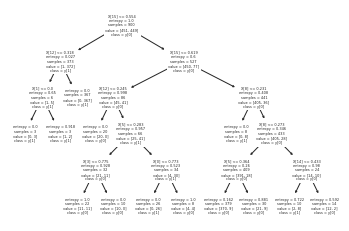

In [93]:
from sklearn.tree import plot_tree

melhor_arvore = max([ [r["test_accuracy"].mean(),r["test_accuracy"].std(),r["estimator"][0]] for r in results_tree_entropy_norm], key=lambda x : x[0])
plot_tree(melhor_arvore[2], class_names=True)
